# Classification. Linear models and KNN

In [1215]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [1216]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [1217]:
from sklearn.exceptions import NotFittedError

In [1218]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return 1 / (1 + np.exp(-X.dot(weights)))
    
    def get_loss(self, X, weights, y):
        """Calculate the loss."""
        return np.mean(np.log(1 + np.exp(-X.dot(weights) * y))) + 1 / (2 * self.C) * np.linalg.norm(weights)
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        self.loss_ = [self.get_loss(X_ext, self.weights_, y)]
        for i in range(self.max_iter):
            delta = np.mean(y*X_ext.T*(1 - 1 / (1 + np.exp(-X_ext.dot(self.weights_) * y))), 1) - self.weights_ / self.C
            step = self.eta * delta
            self.weights_ += step
            self.loss_.append(self.get_loss(X_ext, self.weights_, y))
            if np.linalg.norm(step) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        float_p = self.get_sigmoid(X_ext, self.weights_)
        return np.where(float_p < 0.5, -1, 1)

In [1219]:
from sklearn import datasets
from sklearn import metrics

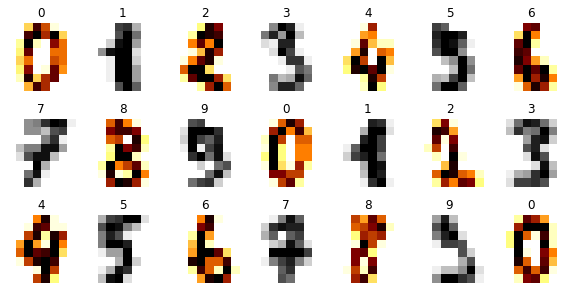

In [1220]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [1221]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [1222]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true', ax=ax, cmap='PiYG')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [1223]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [1224]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [1225]:
lr_clf.fit(X_train, y_train)

In [1226]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [1227]:
model = CustomLogisticRegression()

G:\Programming\ML\ml-intro-2022-5\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


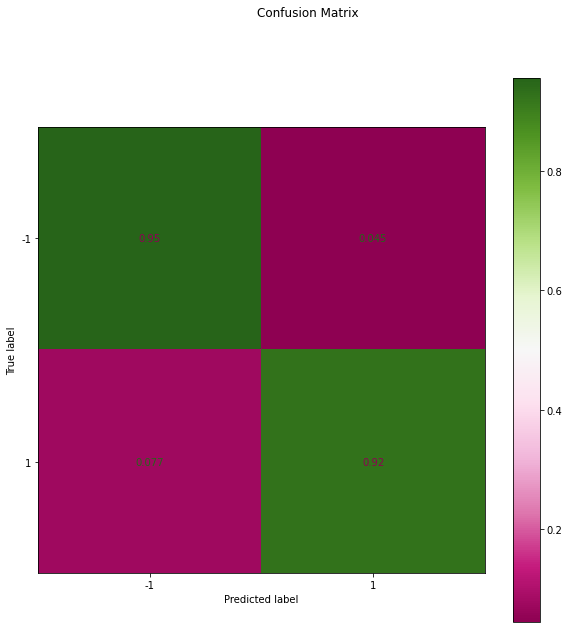

In [1228]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [1229]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [1230]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

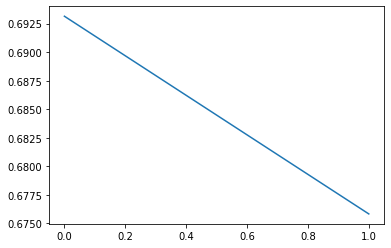

In [1231]:
## your code
plt.plot(lr_clf.loss_)

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

*ВНИМАНИЕ*: по результатам экспериментов для каждого из последующих графиков определено достаточное количество итераций после которого функция потерь принимает постоянное значение либо периодический вид и графики пересозданы с учётом этого.

eta 1e-05 length 51 min 0.7647995574168915
eta 5e-05 length 51 min 0.7174522073669732
eta 0.0001 length 51 min 0.6703696058324096
eta 0.0005 length 51 min 0.5018048714540843
eta 0.001 length 51 min 0.4425842671142245
eta 0.005 length 51 min 0.38792602778224583
eta 0.01 length 51 min 0.6218511027597446
eta 0.05 length 51 min 0.7789536585311577
eta 0.1 length 51 min 0.7789536585311577


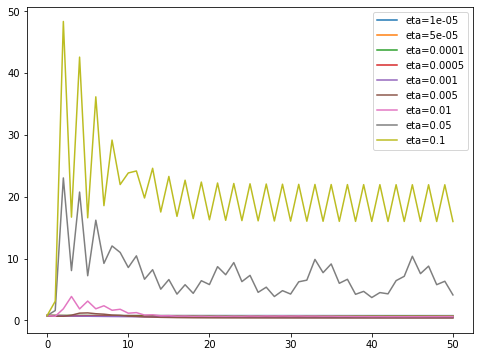

In [1232]:
## your code
plt.figure(figsize=(8, 6))
for eta in [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]:
    clf = CustomLogisticRegression(eta=eta, max_iter=50)
    clf.fit(X_train, y_train)
    print('eta', eta, 'length', len(clf.loss_), 'min', min(clf.loss_))
    plt.plot(clf.loss_, label=f'eta={eta}')
plt.legend()

При слишком маленьком параметре "скорость обучения" за отведённое количество шагов алгоритм не успеет минимизировать функцию потерь (eta <= 0.001), если параметр будет слишком большим, минимизируемая функция будет "перескакивать" через оптимум (хорошо видно для eta >= 0.05).

**(0.5 points)** Try different regularization parameter values and compare the model quality.

C 0.0 length 31 min 0.7789536585311577
C 0.5 length 31 min 0.7789536585311577
C 1.0 length 31 min 0.7789536585311577
C 1.5 length 31 min 0.7789536585311577
C 2.0 length 31 min 0.7789536585311577
C 2.5 length 31 min 0.7789536585311577
C 3.0 length 31 min 0.7789536585311577
C 3.5 length 31 min 0.7789536585311577
C 4.0 length 31 min 0.7789536585311577
C 4.5 length 31 min 0.7789536585311577
C 5.0 length 31 min 0.7789536585311577


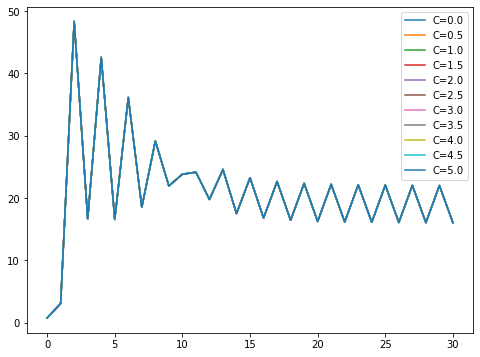

In [1233]:
## your code
plt.figure(figsize=(8, 6))
for c in np.linspace(0, 5, 11):
    clf = CustomLogisticRegression(eta=eta, max_iter=30)
    clf.fit(X_train, y_train)
    print('C', c, 'length', len(clf.loss_), 'min', min(clf.loss_))
    plt.plot(clf.loss_, label=f'C={c:.1f}')
plt.legend()

Изменение параметра регуляризации ни на что не повлияло. Предположение: отсутствие мультиколлинеарности.

**(0.5 points)** Compare zero initialization and random initialization. 

zero_init True length 201 min 0.3895623963581355
zero_init False length 201 min 0.3898842954455587


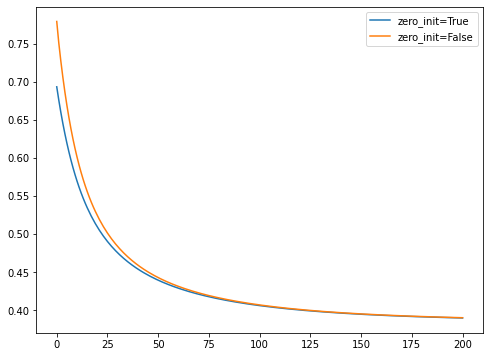

In [1234]:
## your code
plt.figure(figsize=(8, 6))
for zero_init in [True, False]:
    clf = CustomLogisticRegression(zero_init=zero_init, max_iter=200)
    clf.fit(X_train, y_train)
    print('zero_init', zero_init, 'length', len(clf.loss_), 'min', min(clf.loss_))
    plt.plot(clf.loss_, label=f'zero_init={zero_init}')
plt.legend()

В данном случае инициализация весов нулевыми значениями обеспечила более быструю оптимизацию функции потерь.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [1235]:
from numpy import inf
from collections import Counter


class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        n_samples = X.shape[0]
        k_samples = Y.shape[0]
        P = np.zeros((n_samples, k_samples))
        for i in range(n_samples):
            for j in range(k_samples):
                P[i][j] = np.linalg.norm(X[i] - Y[j])
        return P

    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samples,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        counter = Counter()
        for c, w in zip(y, weights):
            counter[c] += w
        return np.array([counter[c] for c in self.classes_])
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)

    @staticmethod
    def find_neighbors(array, n):
        values = [(inf, inf)] * (n + 1)
        for i, v in enumerate(array):
            if v < values[-1][0]:
                values[-1] = (v, i)
                values.sort()

        probs, idx = zip(*values[:-1])
        return np.array(probs), np.array(idx)

    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)

            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / (P + self.eps)

            Y = np.zeros((X.shape[0], self.classes_.shape[0]))
            for i, p in enumerate(P):
                _, idx = self.find_neighbors(p, self.n_neighbors)
                weights = weights_of_points[i][idx]
                classes = self.y[idx]
                for c, w in zip(classes, weights):
                    Y[i][c] += w
                Y[i] /= Y[i].sum()
            return Y
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, 1)]

In [1236]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [1237]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [1238]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

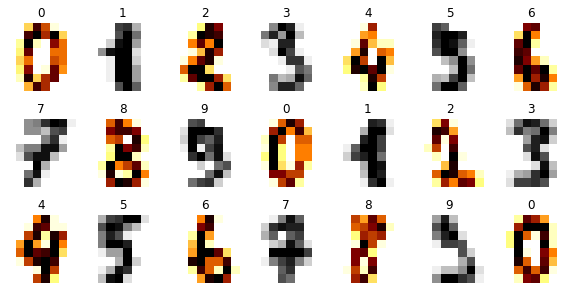

In [1239]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [1240]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [1241]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

G:\Programming\ML\ml-intro-2022-5\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


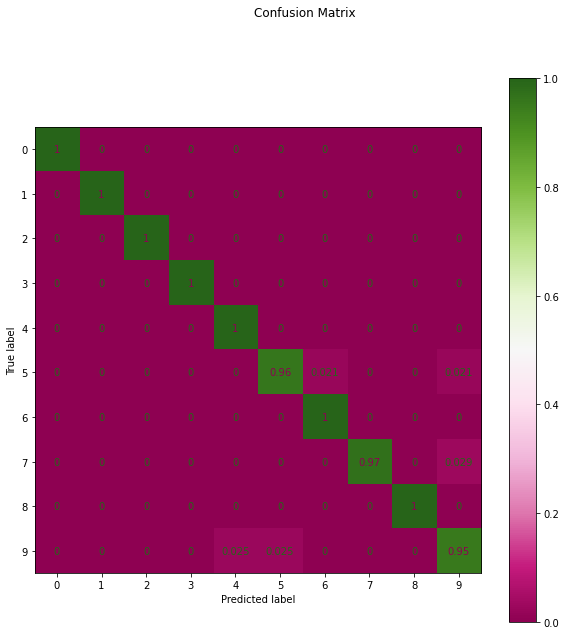

In [1242]:
train_acc, test_acc = fit_evaluate(knn, X_train, y_train, X_test, y_test)

G:\Programming\ML\ml-intro-2022-5\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


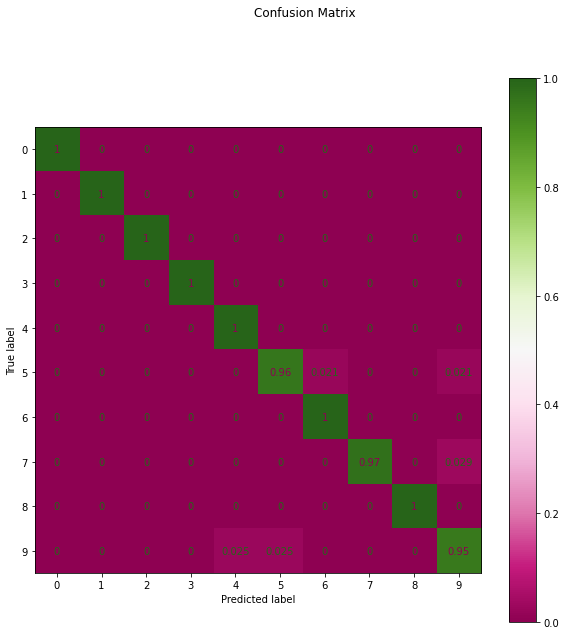

In [1243]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [1244]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Путаются 5 с 6 и 9, 7 с 9 и 9 с 4 и 5... Выше приводился пример искажённых цифр и я сам там 9 кое-где узнать не могу - проблема в схожести начертания.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [1245]:
m = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
m.fit(X_train, y_train)
n_5 = m.predict_proba(X_test)
for k in [1, 3, 4, 5, 6, 7, 11, 15, 21, 31]:
    m = CustomKNeighborsClassifier(n_neighbors=k, weights='distance')
    m.fit(X_train, y_train)
    acc = 0
    for r in m.predict_proba(X_test) - n_5:
        acc += np.linalg.norm(r)
    accuracy = metrics.accuracy_score(y_pred=m.predict(X_test), y_true=y_test)
    print(k, acc, accuracy)

1 10.39475963608231 0.9777777777777777
3 5.397178288341515 0.9833333333333333
4 3.549155400174125 0.9833333333333333
5 0.0 0.9861111111111112
6 3.3328686162932217 0.9888888888888889
7 5.5782395565834015 0.9888888888888889
11 10.40216640103891 0.9833333333333333
15 16.217125438442768 0.9777777777777777
21 22.98088409670686 0.975
31 34.99679137860483 0.975


Для данного случая большей точности можно достичь с числом соседей 6 или 7. Дальнейшее увеличение числа соседей медленно снижает точность.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [1246]:
m = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
m.fit(X_train, y_train)
a = metrics.accuracy_score(y_pred=m.predict(X_test), y_true=y_test)
m = CustomKNeighborsClassifier(n_neighbors=5, weights='uniform')
m.fit(X_train, y_train)
b = metrics.accuracy_score(y_pred=m.predict(X_test), y_true=y_test)
print(a, b)

0.9861111111111112 0.9861111111111112


В данном случае разница незаметна. Предполагаю, что использование distance даст преимущество в случаях, когда классы мало отличимы друг от друга (между ними мало расстояние): в список соседей будут чаще попадать экземпляры других классов.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts > TODO На данный момент мыслей нет, но что-то сделано и в третьем задании.

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts > TODO На данный момент мыслей нет, но что-то сделано и в третьем задании.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [1247]:
PATH = "../data/"

In [1248]:
data = pd.read_csv(os.path.join(PATH, 'train.csv')).set_index('PassengerId')
test_data = pd.read_csv(os.path.join(PATH, 'test.csv')).set_index('PassengerId')

In [1249]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [1250]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [1251]:
data.groupby('Sex').count()['Name']

Sex
female    43886
male      56114
Name: Name, dtype: int64

In [1252]:
data.groupby(['Sex', 'Survived']).count()['Name'] / data.groupby('Sex').count()['Name']

Sex     Survived
female  0           0.288475
        1           0.711525
male    0           0.794205
        1           0.205795
Name: Name, dtype: float64

Мужчин: 56114, женщин 43886 - мужчин на 28% больше, но женщины выживали чаще мужчин (71% и 21% соответственно).

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [1253]:
data.groupby(['Survived'])['Age'].mean()

Survived
0    36.708695
1    40.553799
Name: Age, dtype: float64

In [1254]:
data.groupby(['Survived'])['Age'].median()

Survived
0    36.0
1    43.0
Name: Age, dtype: float64

<AxesSubplot:xlabel='Age', ylabel='Density'>

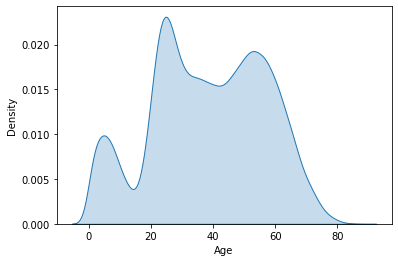

In [1255]:
sns.kdeplot(data=data.Age, label="Survived", shade=True)

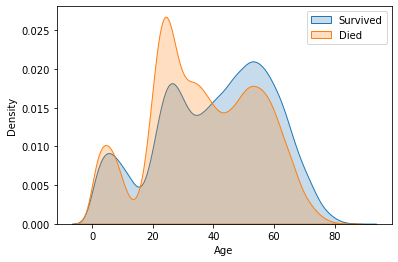

In [1256]:
sns.kdeplot(data=data[data.Survived == 1].Age, label="Survived", shade=True)
sns.kdeplot(data=data[data.Survived == 0].Age, label="Died", shade=True)
plt.legend()

И в численных характеристиках и на графиках видно смещение возраста: выживали пассажиры постарше (медиана 43 против 36). Сам по себе такой возраст не должен являться причиной выживания: скорее к 40 годам выше доход и, следовательно, возможность приобрести более комфортный и безопасный пассажирский класс и т.д..

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

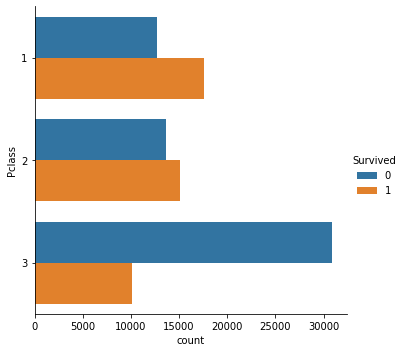

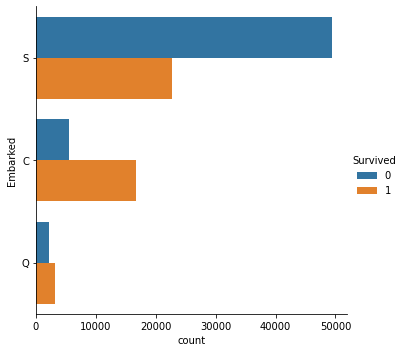

In [1257]:
sns.catplot(y='Pclass', hue='Survived', kind="count", data=data)
sns.catplot(y='Embarked', hue='Survived', kind="count", data=data)

Наибольший шанс выживания у пассажира первого класса. В процентном соотношении (к числу севших в том или ином порту) чаще выживали пассажиры Шербурга.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [1258]:
data.isnull().sum() / data.shape[0] * 100

Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          3.292
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.134
Cabin       67.866
Embarked     0.250
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

На ум приходят несколько подходов:
1) ничего не трогать и попробовать исследовать зависимость пустых значений от других параметров - может быть полезная информация, усложнит нормализацию;
2) удалить кортежи с отсутствующими данными - если кортежей много, мы можем потерять точность обучения;
3) удалить признаки с отсутствующими данными - есть риск существенно ухудшить качество обучения;
4) заполнить пустоты модами - есть риск заполнить ошибочными данными, для задач классификации это даст дисбаланс классов;
5) заполнить средними (для количественных)/модами (для качественных) значениями среди N ближайших соседей - трудоёмко (создаёт отдельную задачу кластеризации/классификации), не сработает для кают, т.к. их ёмкость в реальности ограничена.

Предложение. Использовать комбинацию методов: у Cabin отсутствуют 67% значений и такой признак стоит исключить, остальные заполнить медианой. В Ticket и Name системы не обнаружил и использовать не готов.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [1259]:
y_train = data['Survived']
X_train = data[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].copy()
X_train['is_female'] = data['Sex'].map(lambda x: 1 if x == 'female' else 0)
values = {k: X_train.mode().iloc[0][k] for k in ('Age', 'Fare', 'Embarked')}
X_train.fillna(value=values, inplace=True)
X_train['_embarked'] = X_train['Embarked'].map(lambda x: ['C', 'Q', 'S'].index(x))
X_train.drop(['Embarked'], axis=1, inplace=True)
X_train.isnull().sum() / X_train.shape[0] * 100

Pclass       0.0
Age          0.0
SibSp        0.0
Parch        0.0
Fare         0.0
is_female    0.0
_embarked    0.0
dtype: float64

In [1260]:
f1_train, f1_valid = [], []
for n in range(3, 12, 2):
    knn = KNeighborsClassifier(n_neighbors=n, weights='distance')
    results = cross_validate(knn,
                             X_train, y_train, cv=5, n_jobs=-1,
                             return_train_score=True,
                             scoring='accuracy')
    train_score = np.mean(results['train_score'])
    f1_train.append(train_score)
    test_score = np.mean(results['test_score'])
    f1_valid.append(test_score)
    print(n, train_score, test_score)

3 0.9937425 0.69872
5 0.9937425 0.70941
7 0.9937425 0.7158100000000001
9 0.9937425 0.7189099999999999
11 0.9937425 0.72109


In [1261]:
lr_train, lr_valid = [], []
for c in np.linspace(0.01, 3, 6):
    for l1 in np.linspace(0, 1, 5):
        lr = LogisticRegression(penalty='elasticnet', C=c, max_iter=300, multi_class='ovr',
                                n_jobs=-1, solver='saga', l1_ratio=l1)
        results = cross_validate(Pipeline([('sca', StandardScaler()), ('reg', lr)]),
                                 X_train, y_train, cv=5, n_jobs=-1,
                                 return_train_score=True,
                                 scoring='accuracy')
        train_score = np.mean(results['train_score'])
        lr_train.append(train_score)
        test_score = np.mean(results['test_score'])
        lr_valid.append(test_score)
        print(c, l1, train_score, test_score)

0.01 0.0 0.7668975 0.76692
0.01 0.25 0.76688 0.7669599999999999
0.01 0.5 0.7668925000000001 0.76692
0.01 0.75 0.7668474999999999 0.76705
0.01 1.0 0.7668200000000001 0.76686
0.6080000000000001 0.0 0.7669625000000001 0.7670100000000001
0.6080000000000001 0.25 0.7669650000000001 0.76702
0.6080000000000001 0.5 0.7669599999999999 0.7670399999999999
0.6080000000000001 0.75 0.7669750000000001 0.7670500000000001
0.6080000000000001 1.0 0.7669750000000001 0.7670500000000001
1.2060000000000002 0.0 0.7669625000000001 0.76703
1.2060000000000002 0.25 0.766965 0.76703
1.2060000000000002 0.5 0.766965 0.7670399999999999
1.2060000000000002 0.75 0.7669625000000001 0.76702
1.2060000000000002 1.0 0.7669600000000001 0.76705
1.8040000000000003 0.0 0.7669699999999999 0.76702
1.8040000000000003 0.25 0.7669575 0.76703
1.8040000000000003 0.5 0.7669600000000001 0.76703
1.8040000000000003 0.75 0.7669675 0.7670100000000001
1.8040000000000003 1.0 0.7669625000000001 0.76703
2.402 0.0 0.766955 0.76703
2.402 0.25 0.766

На данный момент лучшие результаты на тестовой сборке у логистической регрессии с C=0.6 и L1_ratio=1.0.

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [1262]:
## your code

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.